# Multivariate time series forecasting with LSTM in Keras

See https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# 1. Dataset 

In this tutorial, we are going to use the Air Quality dataset.

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

In [1]:
import os

In [2]:
# download the dataset
data_dir= "/home/juan/Documents/deep-learning/data/pollution/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
file = os.path.join(data_dir, "pollution.csv")    
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv -O $file

--2018-11-09 12:33:21--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.132.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.132.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1,9M) [text/plain]
Saving to: ‘/home/juan/Documents/deep-learning/data/pollution/pollution.csv’

/home/juan/Document 100%[===================>]   1,92M  5,84MB/s    in 0,3s    

2018-11-09 12:33:22 (5,84 MB/s) - ‘/home/juan/Documents/deep-learning/data/pollution/pollution.csv’ saved [2010492/2010492]



# 2. Data prepartation

The data is not ready to use. We must prepare it first.

Below are the first few rows of the raw dataset.

In [4]:
!head $file

No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0
6,2010,1,1,5,NA,-19,-10,1017,NW,16.1,0,0
7,2010,1,1,6,NA,-19,-9,1017,NW,19.23,0,0
8,2010,1,1,7,NA,-19,-9,1017,NW,21.02,0,0
9,2010,1,1,8,NA,-19,-9,1017,NW,24.15,0,0


The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

In [7]:
import pandas as pd
from datetime import datetime

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv(file,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours, as the instrument wasn't measuring the pollution levels
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
formatted_file = os.path.join(data_dir, 'parsed_pollution.csv') 
dataset.to_csv(formatted_file)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Visualize input data

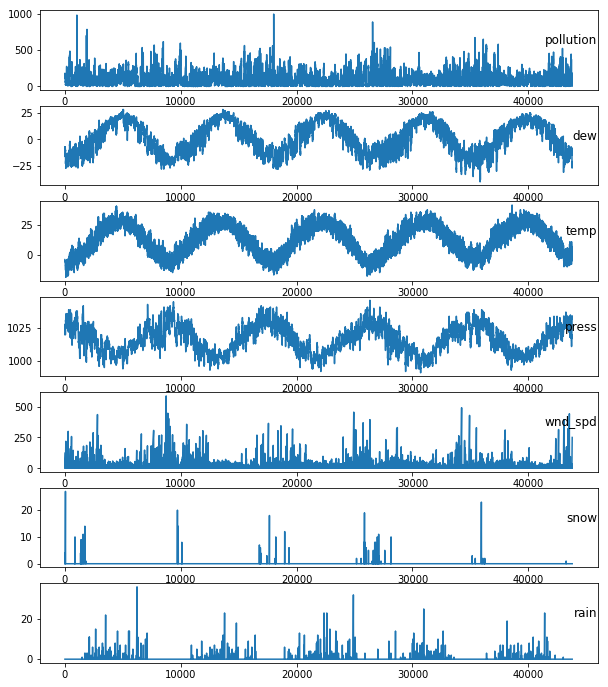

In [13]:
from matplotlib import pyplot as plt
# load dataset
dataset = pd.read_csv(formatted_file, header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()